# Model Maximum Workflows in the Uncertainty Engine SDK

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/digiLab-ai/ue-sdk-helper/blob/main/notebooks/05_model_maximum_workflow.ipynb)

In this notebook, we go through how to get the model maximum from a trained model in the SDK.

## 1. Setup

We start by installing the Uncertainty Engine:

In [1]:
!pip install --quiet uncertainty-engine

And then make our imports:

In [2]:
from uncertainty_engine import Client
import os

We have different methods for interacting with our Uncertainty Engine username and password depending on whether you are using Google Colab or a local python install.

Please update the following accordingly:

In [3]:
is_google_colab = False
is_local = not is_google_colab

### Option A: Google Colab

On the left, click on the key (<img src= width="20"/>). Select `+ Add new secret`.

Then, fill in:

*   ```UE_USERNAME```: your Uncertainty Engine username (email address),
*   ```UE_PASSWORD```: your Uncertainty Engine password,
*   ```UE_ACCOUNT_ID```: your Uncertainty Engine account ID.

It should look like:

<img src= width="500"/>

In [4]:
if is_google_colab:
    from google.colab import userdata

    os.environ["UE_USERNAME"] = userdata.get("UE_USERNAME")
    os.environ["UE_PASSWORD"] = userdata.get("UE_PASSWORD")
    os.environ["UE_ACCOUNT_ID"] = userdata.get("UE_ACCOUNT_ID")


### Option B: Local Use

In the *root* directory of your project, make a file named `.env`. Populate the file with:

```
UE_USERNAME='your_username'
UE_PASSWORD='your_password'
UE_ACCOUNT_ID='your_account_id'
```

Next, make sure that your secrets are never git committed. You can do this by adding `.env` to the `.gitignore` file in your project root directory:
```
.env
```

Then load dotenv:

In [5]:
if is_local:
    !pip install --quiet python-dotenv
    from dotenv import load_dotenv
    # automatically load .env in current directory
    load_dotenv()

### Initialise your Uncertainty Engine client.

In [52]:
client = Client()
client.authenticate()

Now we have told the Uncertainty Engine who we are, we can specify which project we are working on.

In [53]:
PROJECT_NAME = "Demos"

## 2. Maximise Workflow

We are targetting making the below workflow to train a probabilistic machine learning model. This can be created in the GUI and directly interacted with in the SDK, however in this notebook we explicitly create the workflow in the SDK.

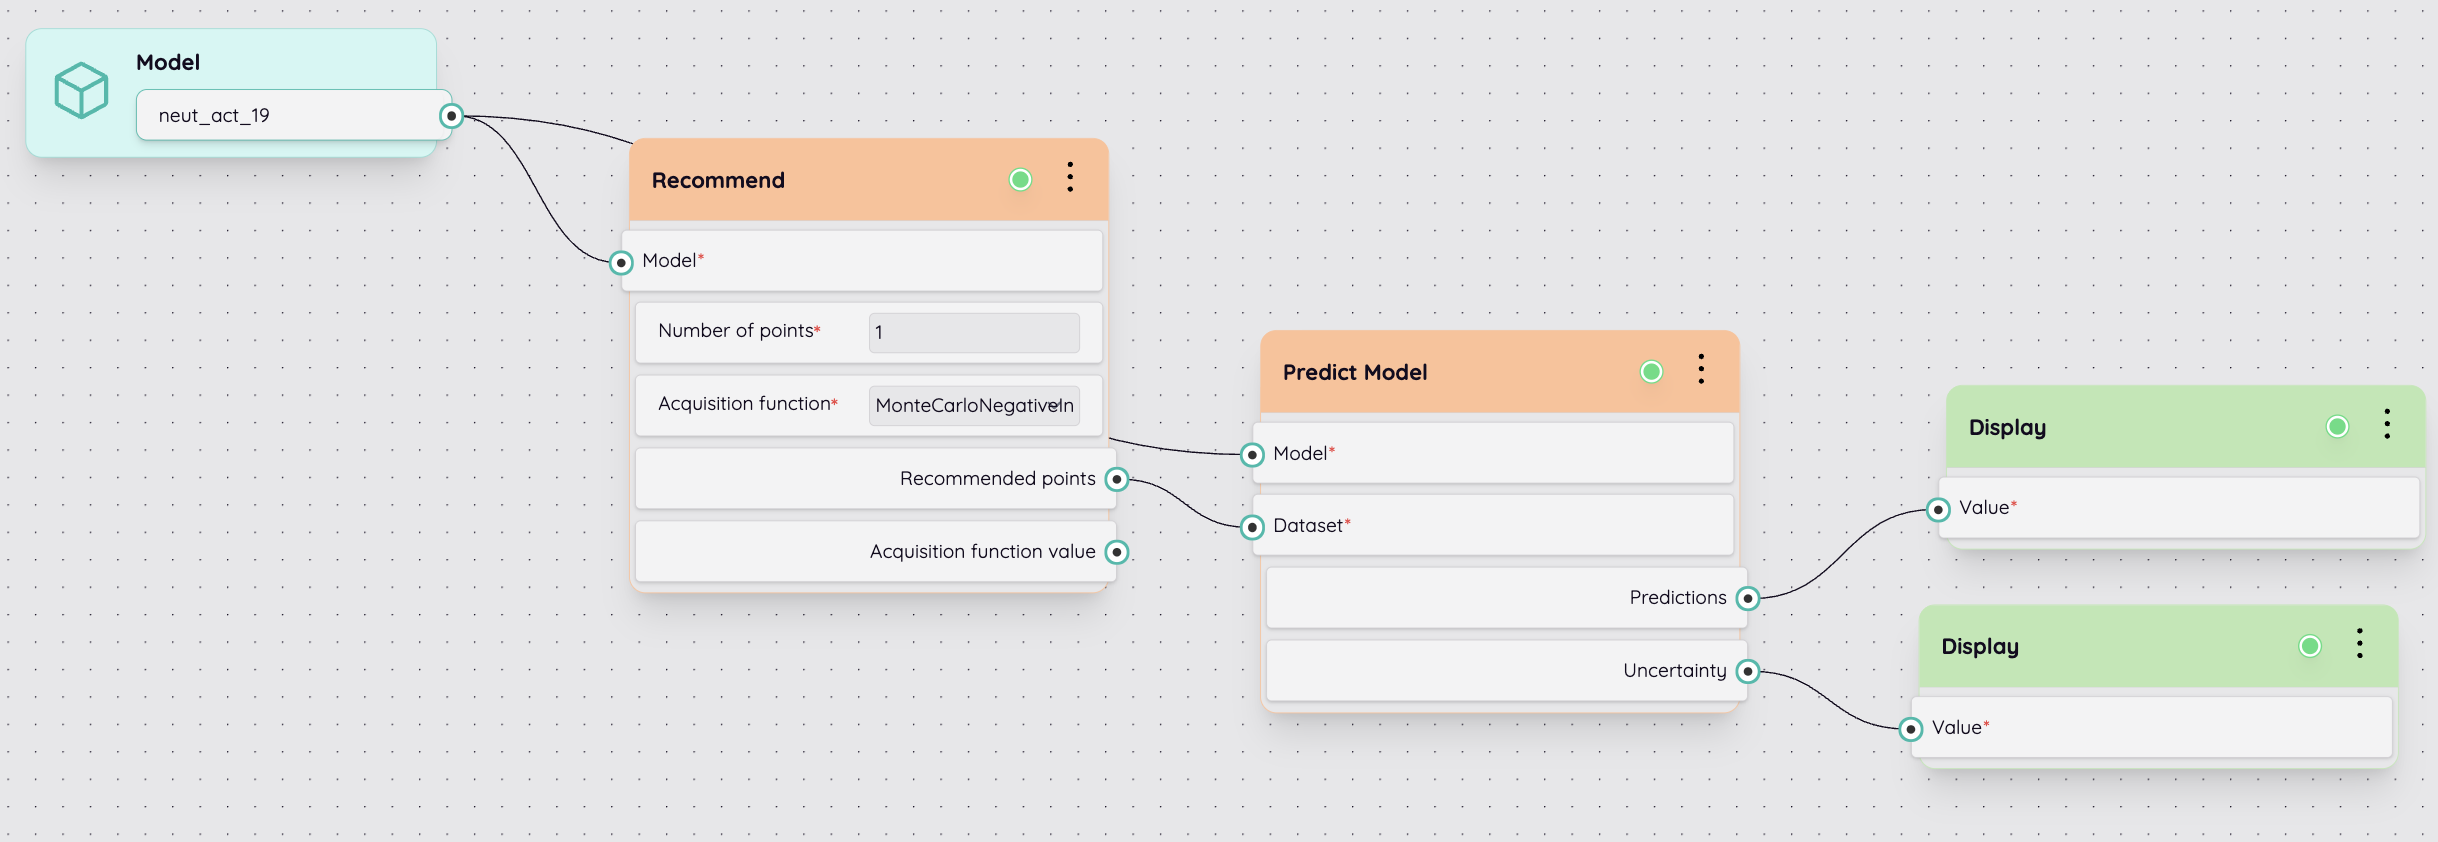

### 2.a. Making/importing helper functions

The Uncertainty Engine follows a graph-based structure. For the purpose of this notebook, we will wrap the workflow as a function to demonstrate how it can be encorporated into existing workflows.

In [ ]:
# imports
from pprint import pprint
from uncertainty_engine.nodes.base import Node
from uncertainty_engine.graph import Graph
from uncertainty_engine.nodes.workflow import Workflow

import json
import numpy as np
import pandas as pd
import io
from typing import Any, Dict, Optional, Union, Iterable, Literal, Tuple

Helper functions:

In [ ]:
# The helper functions developed in earlier notebooks.
from __future__ import annotations

from typing import Any, Dict, Optional, Union, Iterable
import json
import io
import numpy as np
import pandas as pd
import requests
from pprint import pprint

from uncertainty_engine_types import ResourceID
from uncertainty_engine import Client

def get_presigned_url(url: str) -> requests.Response:
    """
    Fetch the contents of a (pre-signed) URL.

    This function replaces the scheme 'https://' with 'http://' prior to the request,
    mirroring the behavior in the original code (some pre-signed endpoints may require it).

    Parameters
    ----------
    url : str
        The original (likely pre-signed) URL.

    Returns
    -------
    requests.Response
        The HTTP response object. Use `.content` / `.text` to access the payload.

    Raises
    ------
    requests.HTTPError
        If the response indicates an HTTP error status.
    """
    url = url.replace("https://", "http://")
    response = requests.get(url)
    response.raise_for_status()
    return response


def wrap_resource_id(resource_id: str) -> Dict[str, Any]:
    """
    Wrap a raw resource ID string into the `ResourceID` pydantic model's dict representation.

    Parameters
    ----------
    resource_id : str
        Raw resource ID.

    Returns
    -------
    dict
        A dictionary produced by `ResourceID(id=resource_id).model_dump()`.
    """
    return ResourceID(id=resource_id).model_dump()


def get_project_id(client: Client, project_name: str) -> str:
    """
    Resolve a project name to its unique project ID.

    Parameters
    ----------
    client : uncertainty_engine.Client
        Initialized API client.
    project_name : str
        Human-readable project name.

    Returns
    -------
    str
        The unique project ID.

    Raises
    ------
    ValueError
        If the project name does not exist.
    """
    projects = client.projects.list_projects()
    for project in projects:
        if project.name == project_name:
            return project.id
    raise ValueError(f"Project with name {project_name!r} not found.")


def get_workflow_id(client: Client, project_name: str, workflow_name: str) -> str:
    """
    Resolve a workflow name (within a project) to its unique workflow ID.

    Parameters
    ----------
    client : uncertainty_engine.Client
        Initialized API client.
    project_name : str
        Project name containing the workflow.
    workflow_name : str
        Human-readable workflow name.

    Returns
    -------
    str
        The unique workflow ID.

    Raises
    ------
    ValueError
        If the workflow name does not exist in the given project.
    """
    project_id = get_project_id(client, project_name)
    workflows = client.workflows.list_workflows(project_id)
    for workflow in workflows:
        if workflow.name == workflow_name:
            return workflow.id
    raise ValueError(f"Workflow with name {workflow_name!r} not found in project {project_name!r}.")


def get_resource_id(client: Client, project_name: str, resource_name: str, resource_type: str) -> str:
    """
    Resolve a resource name (within a project) to its unique resource ID.

    Parameters
    ----------
    client : uncertainty_engine.Client
        Initialized API client.
    project_name : str
        Project name containing the resource.
    resource_name : str
        Human-readable resource name.
    resource_type : str
        Resource type (e.g., "dataset", "model", etc.).

    Returns
    -------
    str
        The unique resource ID.

    Raises
    ------
    ValueError
        If the resource name does not exist in the given project.
    """
    project_id = get_project_id(client, project_name)
    resources = client.resources.list_resources(project_id, resource_type=resource_type)
    for resource in resources:
        if resource.name == resource_name:
            return resource.id
    raise ValueError(
        f"Resource with name {resource_name!r} (type={resource_type!r}) not found in project {project_name!r}."
    )


def upload_dataset(
    client: Client,
    project_name: str,
    dataset_name: str,
    file_path: Optional[str] = None,
    dataset: Optional[Union[pd.DataFrame, Dict[str, Iterable[Any]]]] = None,
    is_replace: bool = True,
    is_verbose: bool = False,
) -> None:
    """
    Upload a dataset to a project, from either a CSV file on disk or an in-memory dataset.

    Behavior:
    - If `file_path` is provided, that file is uploaded.
    - Else, if `dataset` is provided, it is written to `{dataset_name}.csv` and uploaded.
    - If the upload fails and `is_replace=True`, an update call is attempted instead.
    - Prints a confirmation upon success.

    Parameters
    ----------
    client : uncertainty_engine.Client
        Initialized API client.
    project_name : str
        Target project name.
    dataset_name : str
        Name to assign to the uploaded dataset resource.
    file_path : str, optional
        Path to a CSV file to upload.
    dataset : pandas.DataFrame or dict-like, optional
        In-memory dataset to upload. If dict-like, it will be converted to a DataFrame.
        Only used if `file_path` is None.
    is_replace : bool, default True
        If True, attempt to replace/update the existing dataset on error.

    Raises
    ------
    ValueError
        If neither `file_path` nor `dataset` is provided.
    """
    project_id = get_project_id(client, project_name)

    # Prepare a CSV on disk if only an in-memory dataset is provided.
    if file_path is None and dataset is not None:
        file_path = f"{dataset_name}.csv"
        df = dataset if isinstance(dataset, pd.DataFrame) else pd.DataFrame(dataset)
        df.to_csv(file_path, index=False)
    elif file_path is None and dataset is None:
        raise ValueError("Either `file_path` or `dataset` must be provided.")

    try:
        client.resources.upload(
            project_id=project_id,
            name=dataset_name,
            resource_type="dataset",
            file_path=file_path,
        )
    except Exception as e:
        if is_replace:
            client.resources.update(
                project_id=project_id,
                resource_id=get_resource_id(client, project_name, dataset_name, resource_type="dataset"),
                resource_type="dataset",
                file_path=file_path,
            )
        else:
            print(f"Error uploading dataset: {e}")
            return
    if is_verbose:
        print(f"Uploaded {dataset_name!r} to project {project_name!r}.")


def get_node_info(client: Client, node_name: str) -> None:
    """
    Print details for a specific node by its ID/name, using the client's `list_nodes()`.

    Parameters
    ----------
    client : uncertainty_engine.Client
        Initialized API client.
    node_name : str
        Node identifier to look up (as returned by `list_nodes()`).

    Returns
    -------
    None
        This function prints the node info to stdout.
    """
    nodes = client.list_nodes()
    nodes_by_id = {node["id"]: node for node in nodes}
    pprint(nodes_by_id[node_name])


def get_resource(client,
             project_name: str,
             resource_name: str,
             resource_type: str):
    """
    Download a resource from the Uncertainty Engine.
    :param client: The Uncertainty Engine client.
    :param project_name: The name of the project.
    :param resource_name: The name of the dataset.
    :return: The dataset as a pandas DataFrame.
    """
    response: bytes = client.resources.download(
        project_id=get_project_id(client=client, project_name=project_name),
        resource_type=resource_type,
        resource_id=get_resource_id(
            client=client,
            project_name=project_name,
            resource_name=resource_name,
            resource_type=resource_type,
        ),
    )
    decoded = response.decode("utf-8")
    return decoded


def get_data(client: Client, project_name: str, dataset_name: str) -> pd.DataFrame:
    """
    Download a named dataset from a project and return it as a pandas DataFrame.

    Parameters
    ----------
    client : uncertainty_engine.Client
        Initialized API client.
    project_name : str
        Name of the project containing the dataset.
    dataset_name : str
        Name of the dataset resource to download.

    Returns
    -------
    pandas.DataFrame
        Parsed dataset as a DataFrame.

    Raises
    ------
    ValueError
        If the project or dataset cannot be resolved to IDs.
    """
    decoded = get_resource(
        client=client,
        project_name=project_name,
        resource_name=dataset_name,
        resource_type='dataset'
    )
    df = pd.read_csv(io.StringIO(decoded))
    return df

def get_model(client,
                project_name: str,
                model_name: str):
    
    decoded = get_resource(
        client=client,
        project_name=project_name,
        resource_name=model_name,
        resource_type='model'
    )
    model = json.loads(decoded)
    return model

def get_model_inputs(client,
                     project_name: str,
                     model_name: str) -> Iterable[str]:
    """
    Get the input feature names for a model.
    :param client: The Uncertainty Engine client.
    :param project_name: The name of the project.
    :param model_name: The name of the model.
    :return: A list of input feature names.
    """
    model = get_model(
        client=client,
        project_name=project_name,
        model_name=model_name
    )
    input_features = model['metadata']['inputs']
    return input_features


Main maximise workflow:

In [ ]:
def get_model_maximum_workflow(
    client: Client,
    project_name: str,
    model_name: str,
    number_of_points: int = 1,
    acquisition_function: Literal[
        "ExpectedImprovement",
        "LogExpectedImprovement",
        "PosteriorMean",
        "MonteCarloExpectedImprovement",
        "MonteCarloLogExpectedImprovement",
    ] = "PosteriorMean",
    is_visualise_workflow: bool = False,
    is_print_full_output: bool = False,
    save_workflow_name: Union[str, None] = None,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Build and execute a workflow that loads a saved model, proposes up to
    `number_of_points` locations that *maximize the objective* according to the
    chosen acquisition function, and then evaluates the model at those points to
    return predictions and uncertainties.

    The constructed workflow is:
        1) LoadModel
        2) Recommend(acquisition_function, number_of_points)
        3) PredictModel(dataset = recommended_points, model = loaded model)
        4) Download(prediction), Download(uncertainty)

    Parameters
    ----------
    client : Client
        Uncertainty Engine client instance (already authenticated).
    project_name : str
        Name of the project containing the saved model.
    model_name : str
        Name of the saved model resource to load for recommendation and prediction.
    number_of_points : int, default 1
        How many candidate maximizers to propose.
    acquisition_function : {"ExpectedImprovement", "LogExpectedImprovement",
                            "PosteriorMean",
                            "MonteCarloExpectedImprovement", "MonteCarloLogExpectedImprovement"},
        default "PosteriorMean"
        Acquisition used to propose maximizers:
        - **ExpectedImprovement (EI):** Classic improvement over current best (greedy-exploit with exploration).
        - **LogExpectedImprovement:** Log-space EI, numerically stabler for tiny improvements.
        - **PosteriorMean:** Greedy exploitation of the model mean (argmax of mean).
        - **MonteCarloExpectedImprovement (MC-EI):** EI estimated via posterior MC samples (better for batches/multi-modality).
        - **MonteCarloLogExpectedImprovement (MC-log-EI):** Log-space MC EI for numerical stability.

    is_visualise_workflow : bool, default False
        If True, pretty-print the constructed graph nodes for debugging.
    is_print_full_output : bool, default False
        If True, pretty-print the full response payload from workflow execution.
    save_workflow_name : str or None, default None
        If provided, saves the workflow definition under this name in the project.

    Returns
    -------
    (pandas.DataFrame, pandas.DataFrame)
        Tuple of `(predictions_df, uncertainty_df)` evaluated at the recommended points.
        Columns reflect the model outputs and their associated uncertainties.

    Raises
    ------
    ValueError
        If `acquisition_function` is not one of the supported options.
    RuntimeError
        Propagated from the underlying client if workflow execution fails.

    Notes
    -----
    - This routine targets **maximization**. For minimization, maximize the negative
      of the objective (or use an equivalent acquisition configured for minimization).
    - Assumes availability of "LoadModel", "Recommend", "PredictModel", and "Download" nodes.

    Examples
    --------
    >>> preds_df, uncert_df = get_model_maximum_workflow(
    ...     client=ue_client,
    ...     project_name="Personal",
    ...     model_name="gp_emulator",
    ...     number_of_points=5,
    ...     acquisition_function="ExpectedImprovement",
    ... )
    >>> preds_df.head(), uncert_df.head()
    """
    # 1) Build graph.
    graph = Graph()

    # 2a) Load the trained model.
    load_model = Node(
        node_name="LoadModel",
        label="Load Model",
        file_id=wrap_resource_id(
            get_resource_id(
                client=client,
                project_name=project_name,
                resource_name=model_name,
                resource_type="model",
            )
        ),
        project_id=get_project_id(client=client, project_name=project_name),
    )
    graph.add_node(load_model)

    # 2d) Predict with uncertainty.
    recommend_model = Node(
        node_name="Recommend",
        label="Recommend",
        model=load_model.make_handle("file"),
        acquisition_function=acquisition_function,
        number_of_points=number_of_points,
    )
    graph.add_node(recommend_model)

    # 2d) Predict with uncertainty.
    predict_model = Node(
        node_name="PredictModel",
        label="Predict Model",
        dataset=recommend_model.make_handle("recommended_points"),
        model=load_model.make_handle("file"),
    )
    graph.add_node(predict_model)

    # 2e) Download artifacts (predictions + uncertainty as CSVs).
    download_predict = Node(
        node_name="Download",
        label="Download Prediction",
        file=predict_model.make_handle("prediction"),
    )
    graph.add_node(download_predict)

    download_uncertainty = Node(
        node_name="Download",
        label="Download Uncertainty",
        file=predict_model.make_handle("uncertainty"),
    )
    graph.add_node(download_uncertainty)

    if is_visualise_workflow:
        pprint(graph.nodes)

    # Finalize workflow payload (explicitly request both artifacts).
    workflow = Workflow(
        graph=graph.nodes,
        inputs=graph.external_input,
        external_input_id=graph.external_input_id,
        requested_output={
            "Predictions": download_predict.make_handle("file").model_dump(),
            "Uncertainty": download_uncertainty.make_handle("file").model_dump(),
        },
    )

    # Optionally persist the workflow definition.
    if save_workflow_name is not None:
        client.workflows.save(
            project_id=get_project_id(client=client, project_name=project_name),
            workflow=workflow,
            workflow_name=save_workflow_name,
        )

    # Execute inference.
    response = client.run_node(workflow)
    if is_print_full_output:
        pprint(response.model_dump())

    # Fetch artifacts via presigned URLs and load to DataFrames.
    predictions_response = get_presigned_url(response.outputs["outputs"]["Predictions"])
    predictions_df = pd.read_csv(StringIO(predictions_response.text))

    uncertainty_response = get_presigned_url(response.outputs["outputs"]["Uncertainty"])
    uncertainty_df = pd.read_csv(StringIO(uncertainty_response.text))

    return predictions_df, uncertainty_df


Make a predict workflow.

In [58]:
get_node_info('PredictModel')

{'cache_url': 'redis-13325.c338.eu-west-2-1.ec2.redns.redis-cloud.com',
 'category': 'MachineLearningModels',
 'cost': 5,
 'description': 'Make predictions using a machine-learning model',
 'id': 'PredictModel',
 'image_name': 'uncertainty-engine-predict-model-node',
 'inputs': {'dataset': {'default': None,
                        'description': 'Dataset for predictions',
                        'label': 'Dataset',
                        'required': True,
                        'set_in_node': False,
                        'type': 'CSVDataset'},
            'model': {'default': None,
                      'description': 'Machine-learning model',
                      'label': 'Model',
                      'required': True,
                      'set_in_node': False,
                      'type': 'MachineLearningModel'}},
 'label': 'Predict Model',
 'load_balancer_url': None,
 'long_description': 'Generate predictions using a trained machine-learning '
                     'model.',


In [ ]:
def predict_model_workflow(client, 
                           predict_dataset: Optional[Union[str, pd.DataFrame, Dict[str, Iterable[Any]]]], 
                   project_name: str,
                   model_name: str,
                   input_names: Union[list, None] = None,
                   is_visualise_workflow: bool = False,
                   is_print_full_output: bool = False) -> dict:
    """
    A workflow that trains a machine learning model.
    Here, we assume all resources have already been uploaded to the cloud.
    :param client: The Uncertainty Engine client.
    :param project_name: The name of the project.
    :param dataset_name: The name of the dataset.
    :param input_names: The names of the input columns.
    :param output_names: The names of the output columns.
    :param save_model_name: The name to save the trained model as.
    :param is_visualise_workflow: Whether to print the workflow graph.
    :param is_print_full_output: Whether to print the full output of the workflow.
    :return: The response from running the workflow.
    """
    predict_dataset_name = '_predict_data'
    is_upload_dataset = type(predict_dataset) is not str
    if is_upload_dataset:
        upload_dataset(
            client=client,
            project_name=project_name,
            dataset_name=predict_dataset_name,
            dataset=predict_dataset
        )
    else:
        predict_dataset_name = predict_dataset
    
    input_dataset = get_data(
        client=client,
        project_name=project_name,
        dataset_name=predict_dataset_name
    )
    if input_names is None:
        # input_names are the input_dataset columns
        input_names = input_dataset.columns.tolist()
    else:
        # Check that the input names exist in the dataset
        missing = set(input_names) - set(input_dataset.columns)
        if missing:
            raise ValueError(
                f"The following input_names are missing from dataset columns: {sorted(missing)}\n"
                f"Available columns: {input_dataset.columns.tolist()}"
            )
        
    # check the model's expected inputs
    expected_inputs = get_model_inputs(
        client=client,
        project_name=project_name,
        model_name=model_name,
    )
    missing = set(input_names) - set(expected_inputs)
    if missing:
        raise ValueError(
            f"The following input_names are missing from dataset columns: {sorted(missing)}\n"
            f"Available columns: {input_dataset.columns.tolist()}"
        )
    # 1. Create the graph
    graph = Graph()

    # 2. Create relevant nodes, handles, and add to graph:

    # 2.a. 
    
    # 2.a. Load dataset node
    load_data = Node(
        node_name="LoadDataset",
        label="Load Dataset",
        file_id=wrap_resource_id(
            get_resource_id(
                client=client,
                project_name=project_name, 
                resource_name=predict_dataset_name, 
                resource_type='dataset')
                ),
        project_id=get_project_id(
            client=client,
            project_name=project_name
            ),
    )
    graph.add_node(load_data)  # add to graph
    dataset = load_data.make_handle("file")  # add handle
    if input_names is not None:
        # 2.b. Filter dataset node for inputs
        input_data = Node(
            node_name="FilterDataset",
            label="Input Dataset",
            columns=input_names,
            dataset=dataset,
        )
        graph.add_node(input_data)  # add to graph
        input_dataset = input_data.make_handle("dataset")  # add handle
    else:
        input_dataset = dataset
    
    # 2.a. Load model node
    load_model = Node(
        node_name="LoadModel",
        label="Load Model",
        file_id=wrap_resource_id(
            get_resource_id(
                client=client,
                project_name=project_name, 
                resource_name=model_name, 
                resource_type='model')
                ),
        project_id=get_project_id(
            client=client,
            project_name=project_name
            ),
    )
    graph.add_node(load_model)  # add to graph
    # 2.d. Predict model node
    predict_model = Node(
        node_name="PredictModel",
        label="Predict Model",
        dataset=input_dataset,
        model=load_model.make_handle("file"),
    )
    graph.add_node(predict_model)  # add to graph
    
    # 2.e. Display node
    download_predict = Node(
        node_name="Download",
        label="Download Prediction",
        file=predict_model.make_handle("prediction"),
    )
    graph.add_node(download_predict)  # add to graph

    # 2.e. Display node
    download_uncertainty = Node(
        node_name="Download",
        label="Download Uncertainty",
        file=predict_model.make_handle("uncertainty"),
    )
    graph.add_node(download_uncertainty)  # add to graph

    if is_visualise_workflow:
        pprint(graph.nodes)

    workflow = Workflow(
        graph=graph.nodes,
        inputs=graph.external_input,
        external_input_id=graph.external_input_id,
        requested_output={
            "Predictions": download_predict.make_handle("file").model_dump(),
            "Uncertainty": download_uncertainty.make_handle("file").model_dump(),
            }
        )
    
    response = client.run_node(workflow)
    if is_print_full_output:
        pprint(response.model_dump())

    # Download the predictions and save as a DataFrame
    predictions_response = get_presigned_url(response.outputs["outputs"]["Predictions"])
    predictions_df = pd.read_csv(StringIO(predictions_response.text))  # Save the predictions to a DataFrame

    # Download the uncertainty and save as a DataFrame
    uncertainty_response = get_presigned_url(response.outputs["outputs"]["Uncertainty"])
    uncertainty_df = pd.read_csv(StringIO(uncertainty_response.text))  # Save the uncertainty to a DataFrame

    # Clean up if the input dataset was uploaded within this function
    if is_upload_dataset:
        try:
            client.resources.delete_resource(
                project_id=get_project_id(
                    client=client,
                    project_name=project_name
                ),
                resource_id=get_resource_id(
                    client=client,
                    project_name=project_name,
                    resource_name=predict_dataset_name,
                    resource_type="dataset"
                ),
                resource_type="dataset",
            )
        except Exception as e:
            # Non-fatal: log or print if desired; don't mask main exceptions
            print(f"[WARN] Failed to delete temp dataset '{predict_dataset_name}': {e}")

    return predictions_df, uncertainty_df

### 2.b. Data Generation

In [60]:
def make_outputs_base(X, output_names):
    """
    Compute outputs deterministically from inputs X).
    Uses simple example rules cycling over inputs:
      y0 = sin(x)
      y1 = x^2
      y2 = exp(-0.1*x)
    """
    in_cols = list(X.columns)
    df = X.copy()

    for j, name in enumerate(output_names):
        x = df[in_cols[j % len(in_cols)]].to_numpy()
        if j % 3 == 0:
            y = np.sin(x)
        elif j % 3 == 1:
            y = x**2
        else:
            y = np.exp(-0.1 * x)
        df[name] = y
    return df

def make_data(input_names, output_names, filepath, n_points=100, seed=None,
              noise_std_cycle=(0.1, 1.0, 0.05), return_arrays=False):
    """
    Generate a synthetic dataset:
      - Builds inputs (linspace, uniform, normal cycling)
      - Calls deterministic base mapping
      - Adds Gaussian noise with stds cycling in noise_std_cycle
      - Saves to CSV
    """
    rng = np.random.default_rng(seed)

    # --- Inputs (simple defaults) ---
    X = {}
    for i, name in enumerate(input_names):
        if i % 3 == 0:
            X[name] = np.linspace(0, 10, n_points)
        elif i % 3 == 1:
            X[name] = rng.uniform(-5, 5, n_points)
        else:
            X[name] = rng.normal(0, 2, n_points)
    X = pd.DataFrame(X)

    # --- Deterministic outputs (noiseless) ---
    df_noiseless = make_outputs_base(X, output_names)

    # --- Add Gaussian noise ---
    df = df_noiseless.copy()
    for j, name in enumerate(output_names):
        std = noise_std_cycle[j % len(noise_std_cycle)]
        df[name] = df_noiseless[name] + rng.normal(0, std, n_points)

    # --- Save ---
    df.to_csv(filepath, index=False)

    if return_arrays:
        return df, df[input_names].to_numpy(), df[output_names].to_numpy()
    return df

To replicate a sparse dataset, we will train with just 20 data points.

In [61]:
input_names = ["x0", "x1"] 
output_names = ["y0", "y1"]
filename = "example"
filepath = f"{filename}.csv"
n_points = 20
make_data(input_names=input_names, 
          output_names=output_names, 
          filepath=filepath,
          n_points=n_points)

,x0,x1,y0,y1
0,0.000000,-1.745622,0.023359,3.823348
1,0.526316,-3.680986,0.526754,14.299733
2,1.052632,-3.110271,0.841437,10.653688
3,1.578947,2.799130,1.010085,6.669630
4,2.105263,2.450621,0.828058,7.211931
5,2.631579,1.470392,0.544299,1.921839
6,3.157895,-3.586263,-0.061796,11.109788
7,3.684211,0.834779,-0.511154,-0.651771
8,4.210526,-4.512123,-0.701310,20.741832
9,4.736842,1.568609,-0.908278,2.041567


### 2.c. Uploading Training Data to Cloud

In [62]:
upload_dataset(client=client,
               project_name=PROJECT_NAME,
               dataset_name=filename,
               file_path=filepath,
               is_replace=True)

Uploaded example to Demos


### 2.d. Training Probabilistic Machine Learning Model

In [63]:
train_and_save_model_workflow(client, 
                   project_name=PROJECT_NAME,
                   dataset_name=filename, 
                   input_names=input_names,
                   output_names=output_names,
                   save_model_name=f'{filename}_model',
                   is_print_full_output=True
                   )

{'inputs': {'external_input_id': '_',
            'graph': {'nodes': {'Input Dataset': {'inputs': {'columns': {'node_handle': 'Input '
                                                                                        'Dataset_columns',
                                                                         'node_name': '_'},
                                                             'dataset': {'node_handle': 'file',
                                                                         'node_name': 'Load '
                                                                                      'Dataset'}},
                                                  'type': 'FilterDataset'},
                                'Load Dataset': {'inputs': {'file_id': {'node_handle': 'Load '
                                                                                       'Dataset_file_id',
                                                                        'node_name': '_'},
         

## 3. Predicting with Trained Model

Since this model is saved to the cloud, we can consider how the SDK and GUI can be used together.

We can define a new test dataset and upload it:

In [64]:
x0 = np.linspace(0, 10, 5)
x1 = np.linspace(-6, 10, 5)
X0, X1 = np.meshgrid(x0, x1)
shape = X0.shape

test_inputs = {
    'x0':       X0.flatten(),
    'x1':       X1.flatten(),
}

test_outputs = make_outputs_base(pd.DataFrame(test_inputs), output_names)

In [69]:
pred, unc = predict_model_workflow(
    client=client,
    predict_dataset=test_inputs,
    project_name=PROJECT_NAME,
    model_name=f'{filename}_model',
    is_print_full_output=False,
)

Uploaded _predict_data to Demos
[WARN] Failed to delete temp dataset '_predict_data': Error deleting resource: API Error: Internal Server Error
Details: Database error: Failed to delete resource: Transaction failed: Failed to delete resource version: Transaction failed: Error deleting version record: Error updating ResourceRecord: Caused by :: Write conflict during plan execution and yielding is disabled. :: Please retry your operation or multi-document transaction., full error: {'errorLabels': ['TransientTransactionError'], 'ok': 0.0, 'errmsg': 'Caused by :: Write conflict during plan execution and yielding is disabled. :: Please retry your operation or multi-document transaction.', 'code': 112, 'codeName': 'WriteConflict', '$clusterTime': {'clusterTime': Timestamp(1760780046, 1), 'signature': {'hash': b'r\xc8^\xfb\x8dR\xc8%\x91\xd8\xb3\x0bF\xfcfz\xea\xb1\xa0\x93', 'keyId': 7522488043299667975}}, 'operationTime': Timestamp(1760780046, 1)}


In [57]:
print(pred)
print(unc)

          y0         y1
0   0.116488  31.151279
1   0.595695  31.550219
2  -0.964771  31.894429
3   0.851669  32.179152
4  -0.500509  32.400529
5   0.095452   4.120958
6   0.623737   4.063606
7  -0.940679   4.073637
8   0.878227   4.150860
9  -0.495704   4.294256
10  0.072825   6.121136
11  0.646688   5.361230
12 -0.911421   4.668419
13  0.898515   4.052202
14 -0.488225   3.520956
15  0.049045  29.539372
16  0.664101  28.987835
17 -0.877568  28.397462
18  0.912137  27.776353
19 -0.478218  27.132941
20  0.024578  24.318769
21  0.675651  24.229330
22 -0.839763  24.121841
23  0.918831  23.997778
24 -0.465878  23.858827
          y0        y1
0   0.132195  1.754041
1   0.122975  1.601984
2   0.091398  1.542203
3   0.106951  1.588135
4   0.110805  1.733788
5   0.108016  0.771141
6   0.094942  0.646508
7   0.083980  0.570505
8   0.087217  0.553771
9   0.095509  0.603490
10  0.096021  0.686363
11  0.083798  0.607189
12  0.095077  0.568397
13  0.084898  0.571067
14  0.106776  0.620094
15  0.10

In [20]:
upload_dataset(
    client=client,
    project_name=PROJECT_NAME,
    dataset_name='test_input',
    dataset=test_inputs
)

Uploaded test_input to Demos


The resources generated in this notebook (input datasets, trained model) are stored in the cloud. This means that they can be ran via the GUI if preferred.

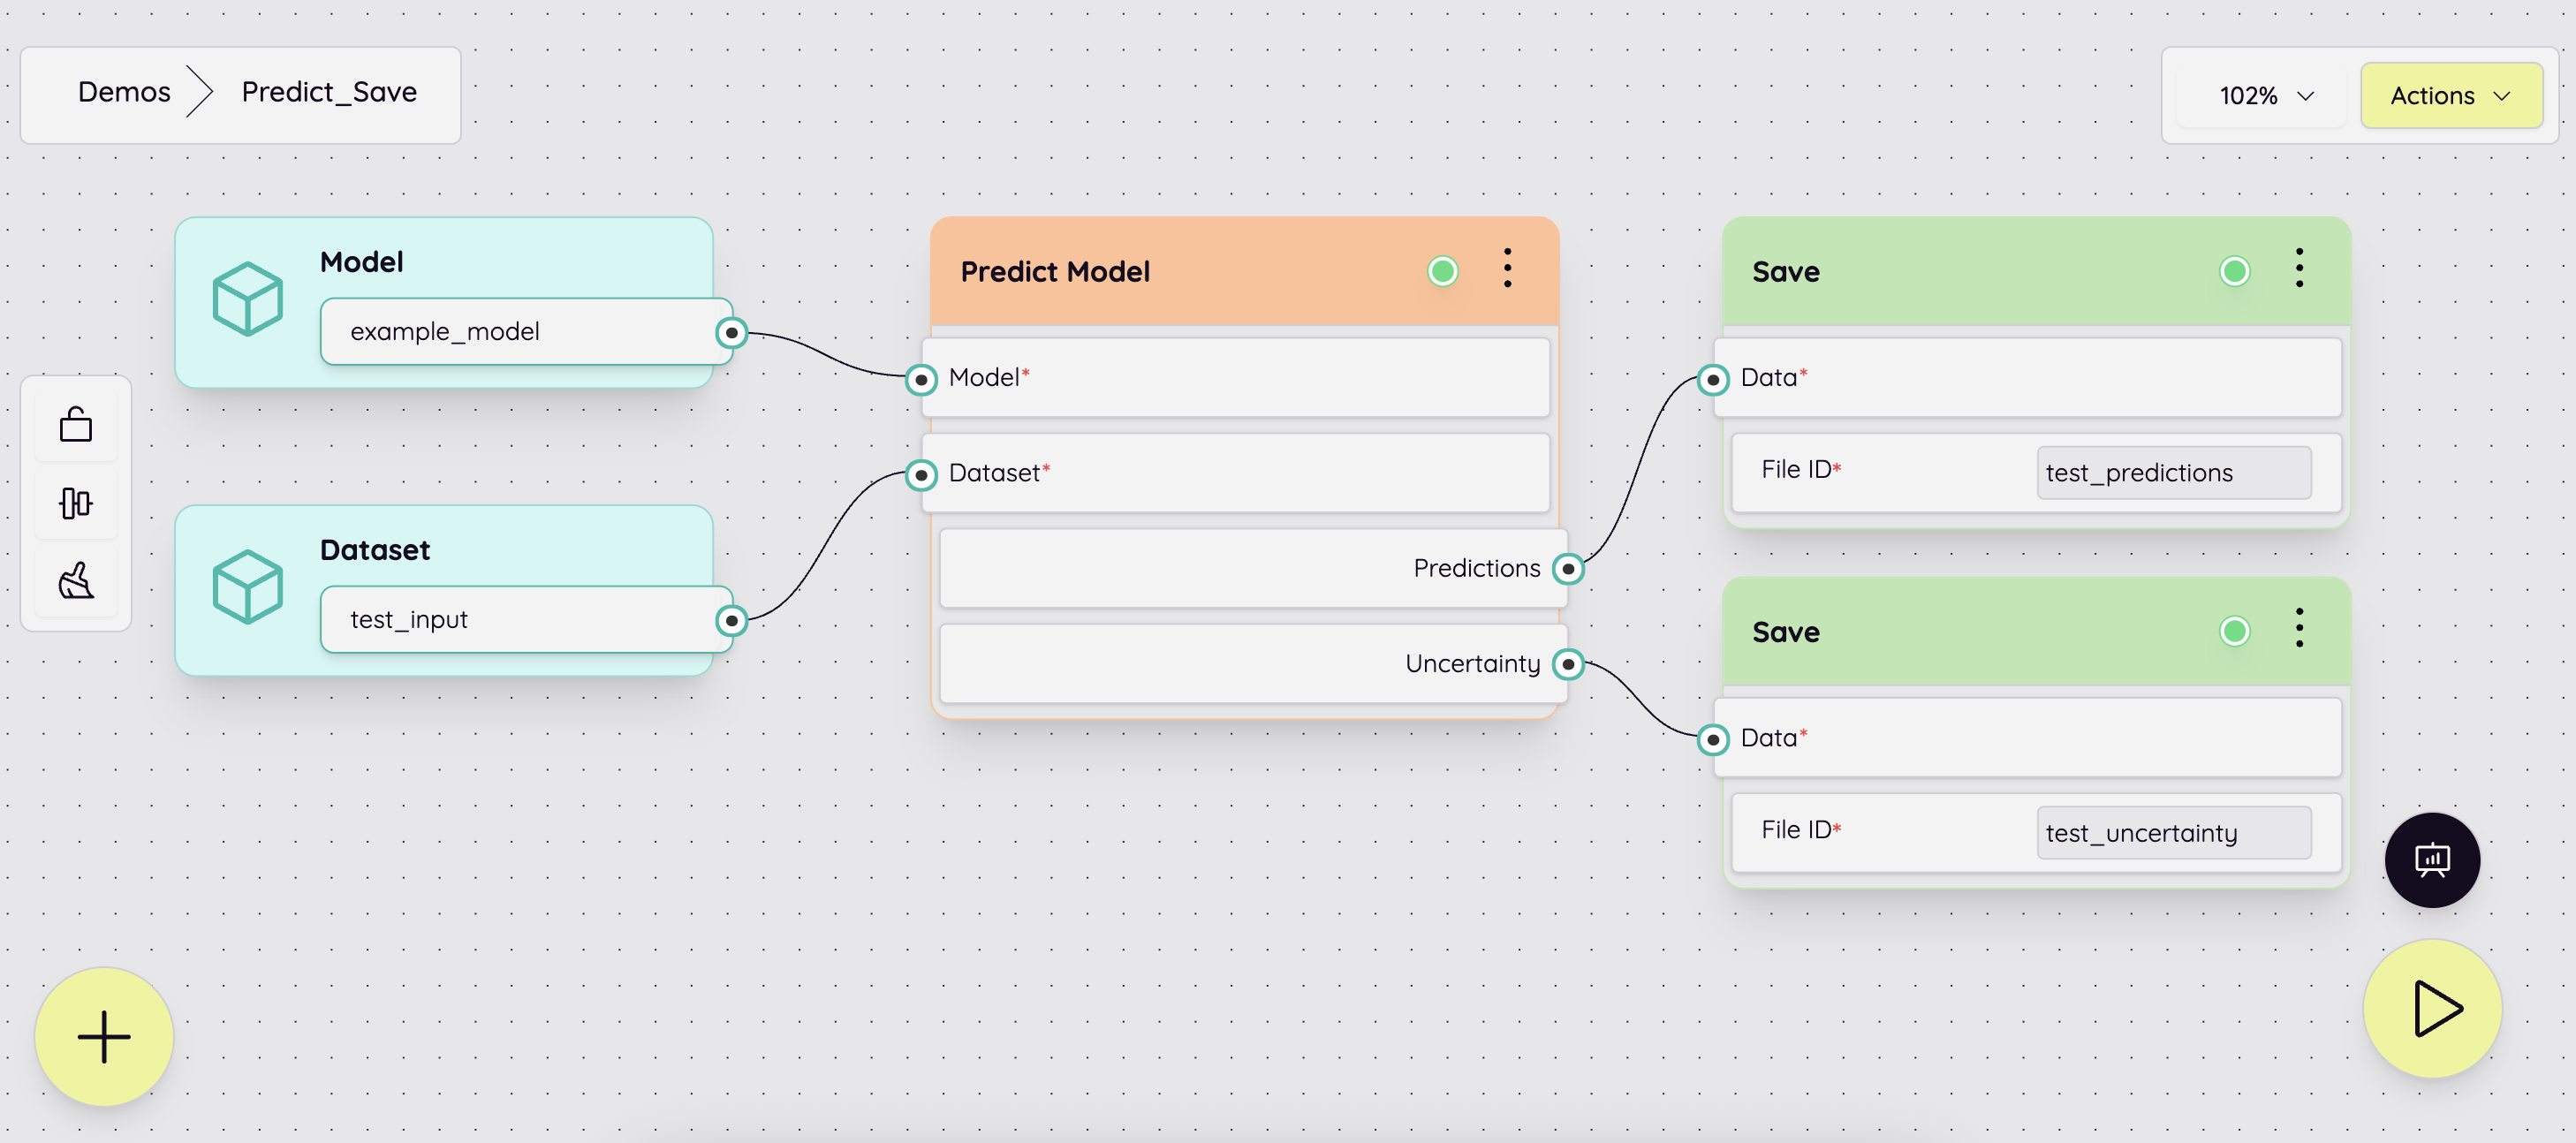

### Visualise Results

After predicting with our trained model in the cloud, we can recover the results to plot.

In [21]:
test_predictions = get_data(
    client=client,
    project_name=PROJECT_NAME,
    dataset_name='test_predictions'
)
test_uncertainty = get_data(
    client=client,
    project_name=PROJECT_NAME,
    dataset_name='test_uncertainty'
)

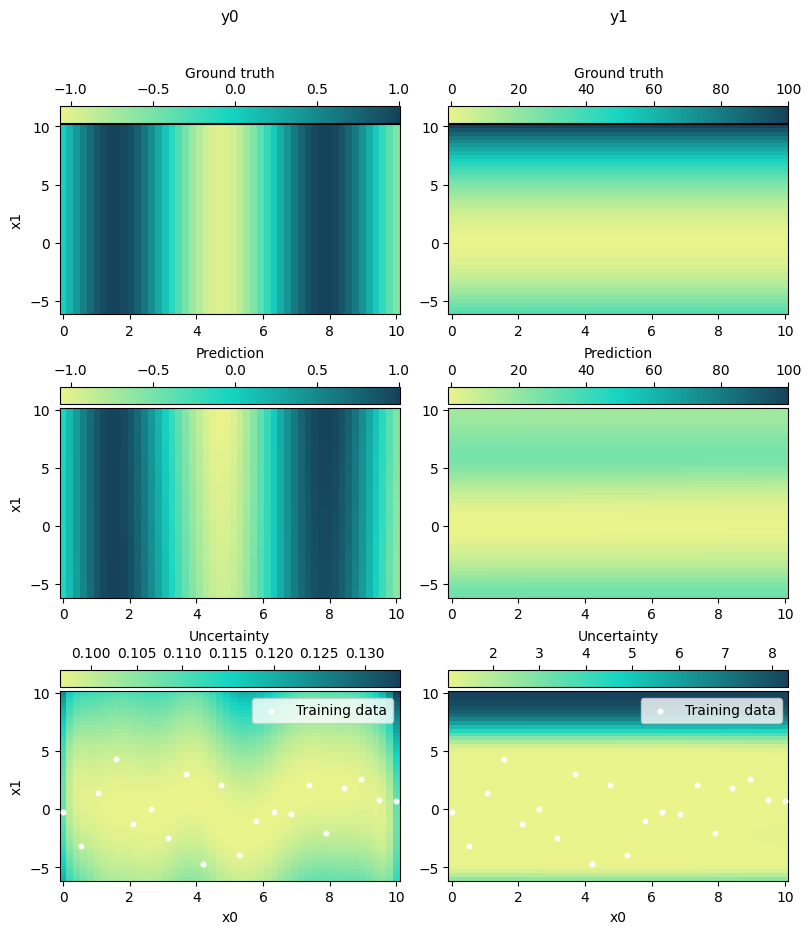

In [22]:
training_inputs = get_data(
    client=client,
    project_name=PROJECT_NAME,
    dataset_name=filename
)

fig, axs = plot_results_grid(
    test_inputs,
    test_predictions,
    test_uncertainty,
    test_outputs,
    training_inputs=training_inputs,
    input_cols=("x0", "x1"),
    output_cols=["y0", "y1"],   # or None to use all columns in test_outputs
    shape=None,                 # inferred automatically if omitted
    cmap=cmap_std,
    suptitle=""
)
plt.show()


## Discussion

In the visualised results above, good agreement was found between the ground truth and model prediction for the y0 (left hand panel) parameter but not the y1 (right hand panel). This was due to the sparse dataset in which the model was trained on. Crucially, this discrepency is exposed through the increased uncertainty in the y1 parameter.

# Conclusion.

In this notebook, we looked at writing a train model workflow in the SDK. Cloud-based resource interaction is highlighted by subsequent prediction with the trained model in the GUI. Of course, this prediction can also be performed via the SDK alone. 

The SDK gives the opportunity to make bespoke plots and visualise the results. These can also be written as *nodes* such that bespoke visualisation can be displayed in either the GUI or SDK.

Now model training can be done, further investigations can be made. The found lengthscales and model hyperparameters are saved in the model ready for closer inspection. Additionally, the *Model Config* node allows for changes to kernels to be made alongside input and output transformations. 

Success? Any problems, contact [dan.greenhouse@digilab.ai](dan.greenhouse@digilab.ai) or submit a ticket at the Help Center: [get.support.uncertaintyengine.ai](get.support.uncertaintyengine.ai).